# Home Exercise on Plagiarism Detection

## Overview

In this exercise, we develop a model that suggests similar products based on a given item. We utilize `Word2Vec()` to train the model and construct a recommendation system.
- Data: https://www.kaggle.com/datasets/samantas2020/online-retail-xlsx

Steps to Solve This Exercise
1. Data preprocessing (Download, Handle Missing Value and Split dataset (train set: 90%,test set:10%))
2. Build a representation model for products in the training dataset. (Model, Vocabulary and Training)
3. Visualize word2vec Embeddings
4. Build a function to compute the similarity of products.
5. This result is based on the vector of a single product. What happens if we want to recommend products to a customer based on the products they have previously chosen?

**Note**: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, and model training. (Submissions that do not follow the guidelines will receive a score of 0.)

In [28]:
%pip install pandas scikit-learn gensim matplotlib numpy kaggle openpyxl tqdm umap-learn

Note: you may need to restart the kernel to use updated packages.


## Import and Download

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os 
import umap.umap_ as umap
import sys
from tqdm import tqdm
import random
import datetime as dt
import platform
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [30]:
tqdm.pandas(desc="Processing text")

In [31]:
pd.set_option("max_colwidth", None)

In [32]:
# Python environment details
print("Python executable being used:", sys.executable)
print("Python version:", sys.version)

# Operating System details
print("Operating System:", platform.system())
print("OS Version:", platform.version())
print("OS Release:", platform.release())

# Machine and architecture details
print("Machine:", platform.machine())

# Visual Studio Code details (based on environment variable)
vscode_info = os.environ.get('VSCODE_PID', None)
if vscode_info:
    print("Running in Visual Studio Code")
else:
    print("Not running in Visual Studio Code")

Python executable being used: e:\anaconda3\envs\ml_env_test\python.exe
Python version: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]
Operating System: Windows
OS Version: 10.0.19045
OS Release: 10
Machine: AMD64
Running in Visual Studio Code


In [33]:
# Set up the Kaggle API command
dataset_name = "samantas2020/online-retail-xlsx"
download_path = "datasets/"  # Change this to your preferred directory

# Ensure the download path exists
os.makedirs(download_path, exist_ok=True)

# Download the dataset using the Kaggle API
os.system(f"kaggle datasets download -d {dataset_name} -p {download_path} --unzip")

print(f"Dataset downloaded and extracted to: {download_path}")


Dataset downloaded and extracted to: datasets/


## Data Preprocessing

In [34]:
# Load the dataset
data_path = "datasets/Online Retail.xlsx"  # Replace with your path
df = pd.read_excel(data_path)

# Display the first few rows
print("Dataset loaded successfully!")


Dataset loaded successfully!


Attribute Information:

**InvoiceNo:**
Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

**StockCode:**
Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

**Description**:
Product (item) name. Nominal.

**Quantity**:
The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**:
Invice date and time. Numeric. The day and time when a transaction was generated.

**UnitPrice**:
Unit price. Numeric. Product price per unit in sterling .

**CustomerID**:
Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

**Country**:
Country name. Nominal. The name of the country where a customer resides.

In [35]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [37]:
# missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [38]:
# remove missing values
df.dropna(inplace=True)

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [39]:
df['StockCode']= df['StockCode'].astype(str)

In [40]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

In [41]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and test set
train_df = df[df['CustomerID'].isin(customers_train)]
test_df = df[~df['CustomerID'].isin(customers_train)]

In [42]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

  1%|▏         | 50/3935 [00:00<00:16, 238.78it/s]

100%|██████████| 3935/3935 [00:11<00:00, 349.58it/s]


In [43]:
# list to capture purchase history of the customers
purchases_test = []

# populate the list with the product codes
for i in tqdm(test_df['CustomerID'].unique()):
    temp = test_df[test_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_test.append(temp)

100%|██████████| 437/437 [00:00<00:00, 542.15it/s]


## Build a representation model for products in the training dataset (Model, Vocab, and Training)

In [44]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)


(3644976, 3681260)

In [45]:
# save word2vec model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [46]:
model.init_sims(replace=True)
print(model)

Word2Vec<vocab=3168, vector_size=100, alpha=0.03>


Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

Shape of `X = (num_words, embedding_dim)`

In [47]:
X = np.array([model.wv[word] for word in model.wv.index_to_key])
X.shape

(3168, 100)

## Visualize word2vec embeddings

Reduce the dimensions of the product embeddings from 100 to 2

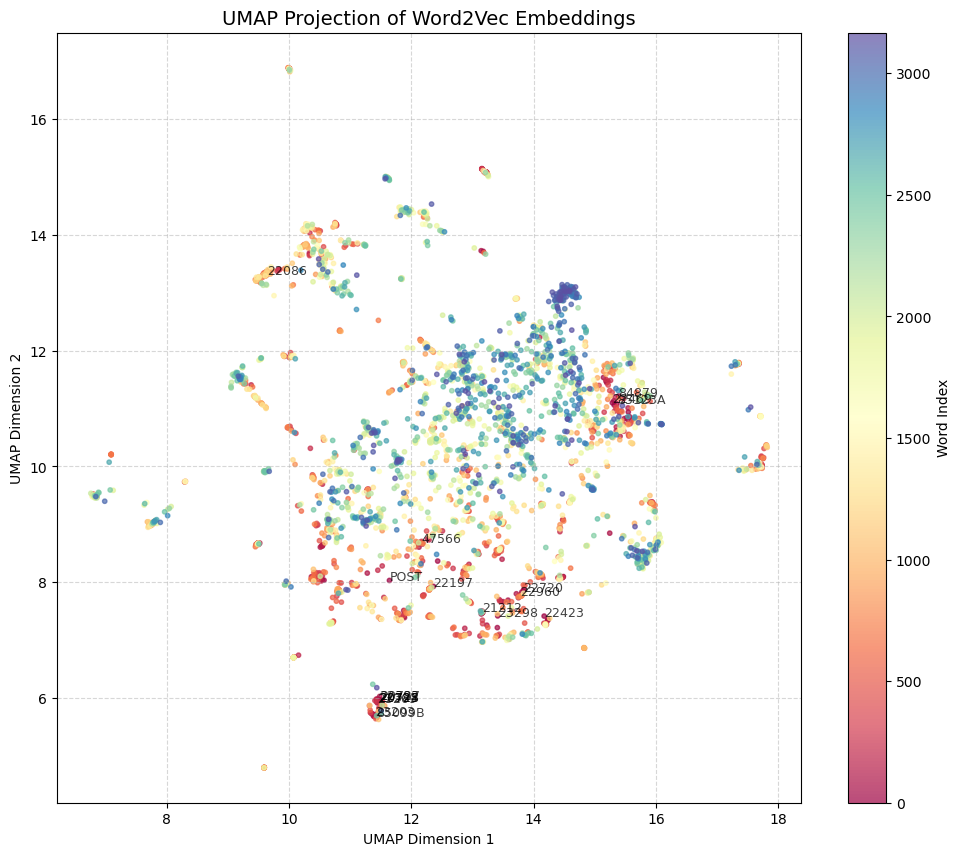

In [48]:
# n_neighbors=30:   Each point considers 30 nearest neighbors to preserve local structure.
# min_dist=0.0:     Controls how closely points are packed (0 = tightly packed).
# n_components=2:   We reduce to 2D for visualization.
# random_state=42:  Ensures reproducibility.
cluster_embedding = umap.UMAP(n_neighbors=30, 
                              min_dist=0.0,
                              n_components=2, 
                              random_state=42).fit_transform(X)

# Create plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], 
                      c=np.arange(len(X)), cmap='Spectral', alpha=0.7, s=10)

# Add colorbar
plt.colorbar(scatter, label="Word Index")

# Annotate some points (optional: first 20 words)
num_annotations = 20
for i, word in enumerate(model.wv.index_to_key[:num_annotations]):
    plt.annotate(word, (cluster_embedding[i, 0], cluster_embedding[i, 1]), 
                 fontsize=9, alpha=0.75)

# Title and labels
plt.title("UMAP Projection of Word2Vec Embeddings", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

## Build a function to calculate the similarity of products 

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [49]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

Product-ID and product-description dictionary

Example: here we get the product-description by the product-id

In [50]:
products_dict['90019A']

['SILVER M.O.P ORBIT BRACELET']

`similar_by_vector` to find those "most" similar vectors in the word2vec models

Example: here we get the list of similar vectors in the word2vec models compared to the input vector

In [51]:
model.wv.similar_by_vector(model.wv['90019A'])

[('90019A', 1.0),
 ('90183A', 0.7875229716300964),
 ('90192', 0.7768809199333191),
 ('90123A', 0.7672466039657593),
 ('90018A', 0.7536517381668091),
 ('90160D', 0.7499523162841797),
 ('90177D', 0.7481251955032349),
 ('90123C', 0.7347043752670288),
 ('90016B', 0.7326786518096924),
 ('90003D', 0.7301982641220093)]

This function makes use of the `similar_by_vector` function, then it map the corresponding product-id to the corresponding product-description

In [52]:
def similar_products(v, n = 10):
    # extract most similar products for the input vector
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [53]:
similar_products(model.wv['90019A'])

[('AMBER DROP EARRINGS W LONG BEADS', 0.7875229716300964),
 ('JADE DROP EARRINGS W FILIGREE', 0.7768809199333191),
 ('PINK HEART OF GLASS BRACELET', 0.7672466039657593),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7536517381668091),
 ('PINK BOUDICCA LARGE BRACELET', 0.7499523162841797),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7481251955032349),
 ('GREEN HEART OF GLASS BRACELET', 0.7347043752670288),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7326786518096924),
 ('CRYSTAL PAIR HEART HAIR SLIDES', 0.7301982641220093),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7292413115501404)]

## This result is based on the vector of a single product. What happens if we want to recommend products to a customer based on the products they have previously chosen?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [54]:
def vectors_aggregation(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [55]:
len(purchases_test[0])

359

The length of the first list of products purchased by a user is 90.

In [56]:
vectors_aggregation(purchases_test[0]).shape

(100,)

Use this result to get the most similar products

In [57]:
similar_products(vectors_aggregation(purchases_test[0]))

[('JUMBO STORAGE BAG SUKI', 0.7274758815765381),
 ('JUMBO BAG RED RETROSPOT', 0.7220747470855713),
 ('JUMBO STORAGE BAG SKULLS', 0.714288055896759),
 ('JUMBO BAG PINK POLKADOT', 0.7092441320419312),
 ('LUNCH BAG RED RETROSPOT', 0.7086468935012817),
 ('CHARLOTTE BAG SUKI DESIGN', 0.7074154615402222),
 ('LUNCH BAG CARS BLUE', 0.7040187120437622),
 ('RECYCLING BAG RETROSPOT ', 0.7012749314308167),
 ('JUMBO BAG STRAWBERRY', 0.6989495754241943),
 ('LUNCH BAG PINK POLKADOT', 0.6963567137718201)]

Below I am giving only the last 10 products purchased as input.

In [58]:
similar_products(vectors_aggregation(purchases_test[0][-10:]))

[('JUMBO STORAGE BAG SKULLS', 0.7195544242858887),
 ('TOY TIDY PINK POLKADOT', 0.7171865105628967),
 ('JUMBO BAG RED RETROSPOT', 0.7020094990730286),
 ('JUMBO BAG PINK POLKADOT', 0.6910417079925537),
 ('JUMBO BAG VINTAGE DOILY ', 0.6900560259819031),
 ('JUMBO STORAGE BAG SUKI', 0.6886303424835205),
 ('JUMBO BAG ALPHABET', 0.6862068176269531),
 ('JUMBO SHOPPER VINTAGE RED PAISLEY', 0.685783326625824),
 ('JUMBO BAG STRAWBERRY', 0.6855788230895996),
 ('JUMBO  BAG BAROQUE BLACK WHITE', 0.6640462279319763)]